<a href="https://colab.research.google.com/github/pinilDissanayaka/Pneumonia-Detection-using-Deep-Learning/blob/main/Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle datasets download tolgadincer/labeled-chest-xray-images

100% 1.17G/1.17G [00:09<00:00, 129MB/s]
100% 1.17G/1.17G [00:09<00:00, 129MB/s]


In [3]:
! unzip /content/labeled-chest-xray-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2565226-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2568157-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-263932-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646645-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646923-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2655558-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2659844-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-00

In [4]:
!pip install livelossplot
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 9.6 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import cv2 as cv
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from livelossplot import PlotLossesKerasTF
import visualkeras

%matplotlib inline

import warnings
warnings.filterwarnings(action = 'ignore')

In [6]:
MAIN_DIR = '/content/chest_xray'

In [7]:
glob(MAIN_DIR + '/*')

['/content/chest_xray/test', '/content/chest_xray/train']

In [27]:
TRAIN_DIR = glob(MAIN_DIR + '/*')[1]
TEST_DIR = glob(MAIN_DIR + '/*')[0]


print(f"Training directory : {TRAIN_DIR}")
print(f"Testing directory : {TEST_DIR}")

Training directory : /content/chest_xray/train
Testing directory : /content/chest_xray/test


In [9]:
TRAIN_CATEGORIES = os.listdir(TRAIN_DIR)
TESTING_CATEGORIES = os.listdir(TEST_DIR)


print(f"Trainging categories : {TRAIN_CATEGORIES}")
print(f"Testing categories : {TESTING_CATEGORIES}")

Trainging categories : ['NORMAL', 'PNEUMONIA']
Testing categories : ['NORMAL', 'PNEUMONIA']


In [10]:
TRAIN_CATEGORIES == TESTING_CATEGORIES

True

In [11]:
for i in glob(MAIN_DIR + '/*'):
  path = glob(i + '/*')
  for j in path:
    imgCount = len(os.listdir(j))
    print(f"{j} has {imgCount} images.")
  print('\n')

/content/chest_xray/test/NORMAL has 234 images.
/content/chest_xray/test/PNEUMONIA has 390 images.


/content/chest_xray/train/NORMAL has 1349 images.
/content/chest_xray/train/PNEUMONIA has 3883 images.




TRAINING NORMAL


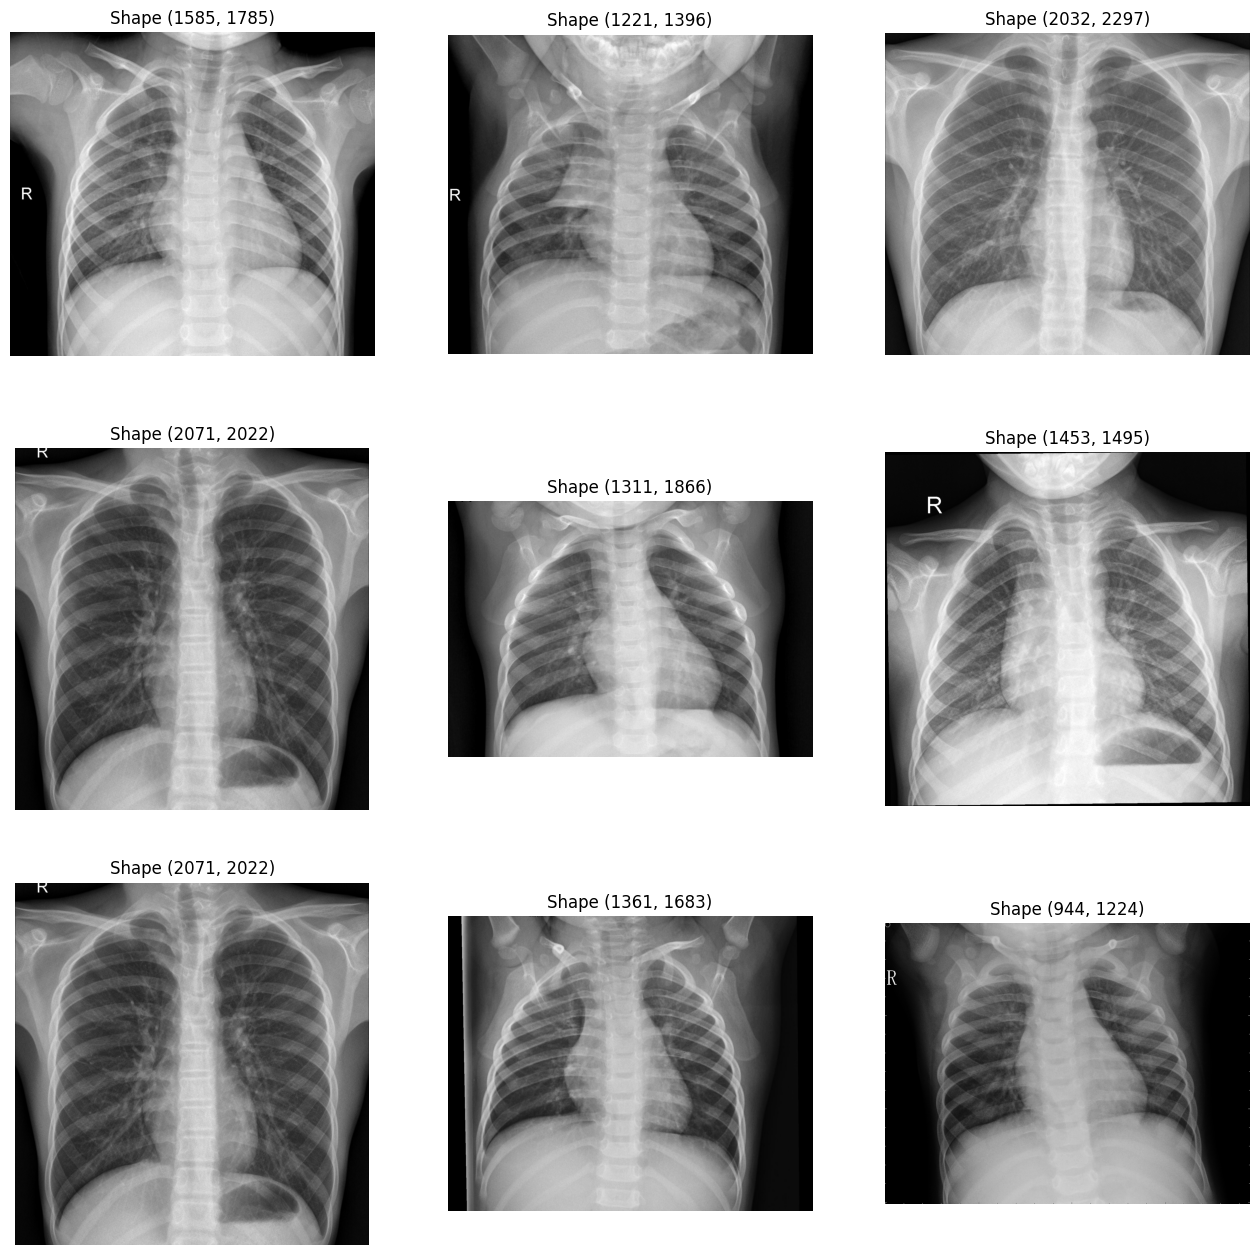

In [15]:
path = random.choices(list(glob(TRAIN_DIR + '/NORMAL/*')), k = 9)
plt.figure(figsize = (16, 16))
print('TRAINING NORMAL')
j = 1
for i in path:
  img = plt.imread(i)
  plt.subplot(3, 3, j)
  plt.imshow(img, cmap='gray')
  plt.title(f"Shape {img.shape}")
  plt.axis('off')
  j = j +1

TRAINING PNEUMONIA


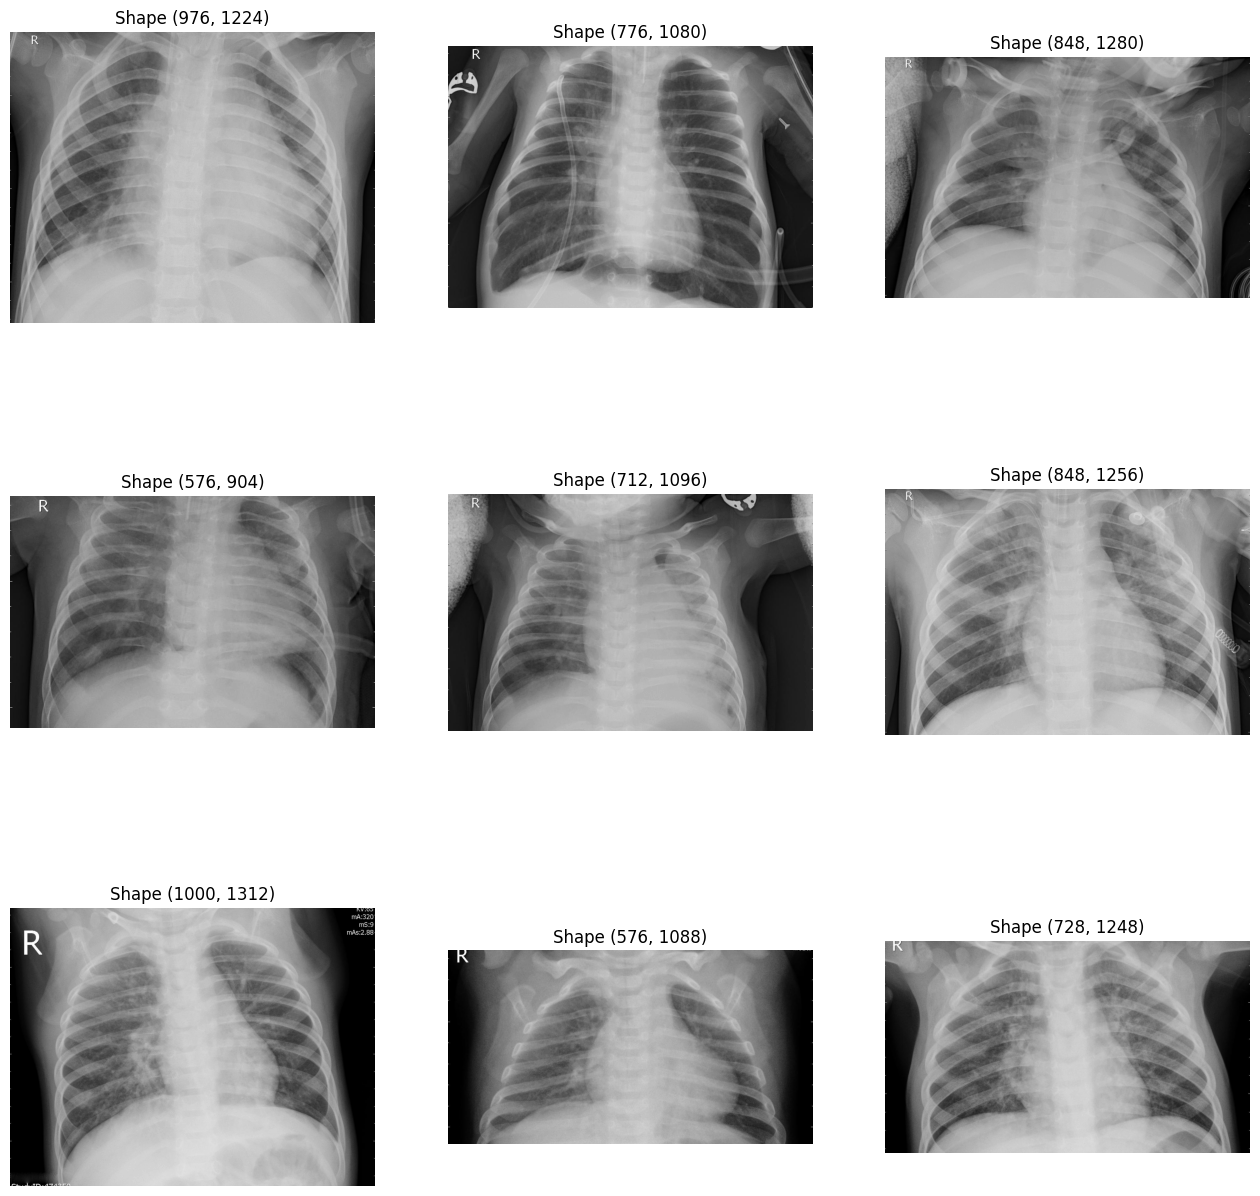

In [16]:
path = random.choices(list(glob(TRAIN_DIR + '/PNEUMONIA/*')), k = 9)
plt.figure(figsize = (16, 16))
print('TRAINING PNEUMONIA')
j = 1
for i in path:
  img = plt.imread(i)
  plt.subplot(3, 3, j)
  plt.imshow(img, cmap='gray')
  plt.title(f"Shape {img.shape}")
  plt.axis('off')
  j = j +1

In [28]:
rescale = 1./255
target_size = (150, 150)
batch_size = 64
class_mode = "binary"


train_datagen = ImageDataGenerator(
    rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)

test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=target_size,
    class_mode=class_mode,
    batch_size= batch_size,
    shuffle = False)

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [29]:
TRAINING_STEPS = train_generator.n // train_generator.batch_size
VALIDATION_STEPS = train_generator.n // train_generator.batch_size